## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
import numpy as np
import torch,librosa

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from symbols import phone2id, tone2id

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 16000


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [54]:
checkpoint_path = "/home/xzhou/tacotron2/outdir/checkpoint_31000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()

#### Prepare text input

In [55]:
test_text_path = "/home/xzhou/tacotron2/data/text/00000003.lab"
sequence = np.loadtxt(test_text_path, 'str')
sequence = np.array([[phone2id[ph], tone2id[tn]] for ph, tn in sequence])[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

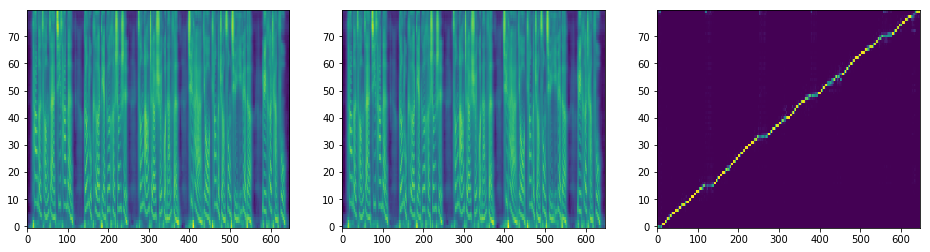

In [56]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

### Tacotron2 Synthesis

In [57]:
def recover_wav(mel):
    n_fft = 2048
    win_length=hparams.win_length
    hop_length=hparams.hop_length
    mean, std = np.load( "/home/xzhou/tacotron2/data/MeanStd_Tacotron_mel.npy")
    mel = mel_outputs.float().data.cpu().numpy()[0].transpose()
    temp1=np.tile(mean, (mel.shape[0],1))
    temp2=np.tile(std, (mel.shape[0],1))
    mel = mel * std + mean
    mel = np.exp(mel).transpose()
    filters = librosa.filters.mel(sr=16000, n_fft=n_fft, n_mels=80)
    inv_filters = np.linalg.pinv(filters)
    spec = np.dot(inv_filters, mel)

    def _griffin_lim(stftm_matrix, shape, max_iter=50):
        y = np.random.random(shape)
        for i in range(max_iter):
            stft_matrix = librosa.core.stft(y, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
            stft_matrix = stftm_matrix * stft_matrix / np.abs(stft_matrix)
            y = librosa.core.istft(stft_matrix, win_length=win_length, hop_length=hop_length)
        return y

    shape = spec.shape[1] * hop_length -  hop_length + 1

    y = _griffin_lim(spec, shape)
    return y

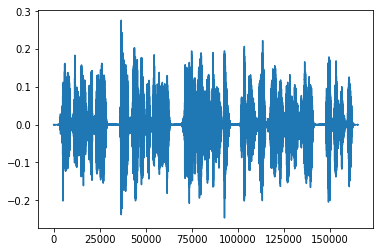

In [58]:
audio=recover_wav(mel_outputs)
plt.plot(audio)
ipd.Audio(audio, rate=hparams.sampling_rate)